# MONAI 脑肿瘤分割 - 训练Notebook

本notebook用于使用MONAI框架训练脑肿瘤分割模型。

## 功能：
1. 完整的数据准备和划分
2. MONAI UNet模型训练
3. 训练过程监控和可视化
4. 模型评估和保存
5. 测试集性能评估


## 1. 安装依赖和挂载Google Drive


In [17]:
# 挂载Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# 安装MONAI和相关依赖
%pip install monai[all] nibabel -q
%pip install matplotlib scikit-image -q


In [19]:
# 导入必要的库
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import nibabel as nib
from pathlib import Path
import json
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# MONAI导入
import monai
from monai.data import Dataset as MonaiDataset, DataLoader as MonaiDataLoader
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    ToTensord,
    Compose,
    RandRotate90d,
    RandFlipd,
    RandShiftIntensityd,
    MapTransform,
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.engines import Trainer, SupervisedEvaluator
from monai.handlers import (
    StatsHandler,
    TensorBoardStatsHandler,
    ValidationHandler,
    CheckpointSaver,
    LrScheduleHandler,
)

print(f"MONAI version: {monai.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


MONAI version: 1.5.1
PyTorch version: 2.9.0+cu126
CUDA available: False


## 2. 配置路径和参数


In [20]:
# 数据路径配置
DRIVE_DATA_PATH = "/content/drive/MyDrive/data-brain-2024"
MODEL_SAVE_PATH = "/content/drive/MyDrive/brain-tumor-models-monai"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# 数据参数
IMG_SIZE = 128  # 图像尺寸
NUM_CLASSES = 4  # 背景、坏死核心、水肿、增强

# 训练超参数
BATCH_SIZE = 2  # 3D数据需要较小的batch size（根据GPU内存调整）
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
VAL_INTERVAL = 1  # 每N个epoch验证一次

# 分割类别
SEGMENT_CLASSES = {
    0: 'Background',
    1: 'NECROTIC/CORE',
    2: 'EDEMA',
    3: 'ENHANCING'
}

# 设置随机种子
set_determinism(seed=42)

print(f"数据路径: {DRIVE_DATA_PATH}")
print(f"模型保存路径: {MODEL_SAVE_PATH}")
print(f"批次大小: {BATCH_SIZE}")
print(f"学习率: {LEARNING_RATE}")
print(f"训练轮数: {NUM_EPOCHS}")


数据路径: /content/drive/MyDrive/data-brain-2024
模型保存路径: /content/drive/MyDrive/brain-tumor-models-monai
批次大小: 2
学习率: 0.001
训练轮数: 100


## 3. 数据加载和预处理


In [21]:
# 自定义变换：合并多模态图像
class ConcatModalitiesd(MapTransform):
    """将多模态图像列表合并为多通道图像"""
    def __init__(self, keys, allow_missing_keys=False):
        super().__init__(keys, allow_missing_keys)

    def __call__(self, data):
        d = dict(data)
        for key in self.key_iterator(d):
            if isinstance(d[key], list):
                # 合并列表中的多个模态为多通道
                d[key] = np.concatenate(d[key], axis=0)  # 在通道维度上合并
        return d

# 自定义变换：将标签值4映射到3
class RemapLabeld(MapTransform):
    """将标签中的值4映射到3（BraTS数据格式）"""
    def __init__(self, keys, allow_missing_keys=False):
        super().__init__(keys, allow_missing_keys)

    def __call__(self, data):
        d = dict(data)
        for key in self.key_iterator(d):
            if isinstance(d[key], torch.Tensor):
                d[key] = torch.where(d[key] == 4, torch.tensor(3, dtype=d[key].dtype, device=d[key].device), d[key])
            elif isinstance(d[key], np.ndarray):
                d[key] = np.where(d[key] == 4, 3, d[key])
        return d

def get_patient_groups(data_path):
    """获取所有患者的数据分组"""
    all_files = glob.glob(os.path.join(data_path, "*.nii"))
    patient_groups = defaultdict(lambda: defaultdict(dict))

    for file_path in all_files:
        filename = os.path.basename(file_path)
        match = re.match(r'BraTS-GLI-(\d+)-(\d+)-(t1n|t2f|t2w|t1c|seg)\.nii', filename)
        if match:
            patient_id = match.group(1)
            sequence_id = match.group(2)
            modality = match.group(3)
            patient_groups[patient_id][sequence_id][modality] = file_path

    complete_patients = {}
    for patient_id, sequences in patient_groups.items():
        for seq_id, modalities in sequences.items():
            if 't2f' in modalities and 't1c' in modalities and 'seg' in modalities:
                if patient_id not in complete_patients:
                    complete_patients[patient_id] = {}
                complete_patients[patient_id][seq_id] = modalities

    return complete_patients

def prepare_monai_data_list(patient_groups, patient_ids):
    """准备MONAI格式的数据字典列表"""
    data_list = []

    for patient_id in patient_ids:
        if patient_id not in patient_groups:
            continue

        for seq_id, modalities in patient_groups[patient_id].items():
            if 't2f' in modalities and 't1c' in modalities and 'seg' in modalities:
                data_dict = {
                    "image": [modalities['t2f'], modalities['t1c']],  # 多模态图像
                    "label": modalities['seg'],
                    "patient_id": patient_id,
                    "sequence_id": seq_id
                }
                data_list.append(data_dict)

    return data_list

# 获取所有患者数据
all_patient_groups = get_patient_groups(DRIVE_DATA_PATH)
patient_ids = list(all_patient_groups.keys())

print(f"找到 {len(patient_ids)} 个患者")
print(f"前5个患者ID: {patient_ids[:5]}")


找到 14 个患者
前5个患者ID: ['00009', '00020', '00027', '00033', '00046']


## 4. 数据划分（训练/验证/测试）


In [22]:
# 数据划分
from sklearn.model_selection import train_test_split

# 准备所有数据
all_data_list = prepare_monai_data_list(all_patient_groups, patient_ids)

# 先按患者ID划分（避免数据泄露）
unique_patient_ids = list(set([item['patient_id'] for item in all_data_list]))
train_patients, temp_patients = train_test_split(
    unique_patient_ids, test_size=0.3, random_state=42
)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.5, random_state=42
)

# 根据患者ID划分数据
train_data_list = [item for item in all_data_list if item['patient_id'] in train_patients]
val_data_list = [item for item in all_data_list if item['patient_id'] in val_patients]
test_data_list = [item for item in all_data_list if item['patient_id'] in test_patients]

print(f"训练集: {len(train_data_list)} 个样本 ({len(train_patients)} 个患者)")
print(f"验证集: {len(val_data_list)} 个样本 ({len(val_patients)} 个患者)")
print(f"测试集: {len(test_data_list)} 个样本 ({len(test_patients)} 个患者)")
print(f"\n训练患者示例: {train_patients[:5]}")
print(f"验证患者示例: {val_patients[:3]}")
print(f"测试患者示例: {test_patients[:3]}")


训练集: 18 个样本 (9 个患者)
验证集: 4 个样本 (2 个患者)
测试集: 5 个样本 (3 个患者)

训练患者示例: ['00469', '00463', '00020', '00080', '00009']
验证患者示例: ['00046', '00096']
测试患者示例: ['00027', '00078', '00472']


## 5. 定义MONAI数据变换


In [23]:
# 训练时的数据变换
train_transforms = Compose([
    LoadImaged(keys=["image", "label"], image_only=False),
    EnsureChannelFirstd(keys=["image", "label"]),
    ConcatModalitiesd(keys=["image"]),  # 合并多模态
    RemapLabeld(keys=["label"]),  # 将标签值4映射到3
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=0.0,
        a_max=1000.0,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    Resized(keys=["image", "label"], spatial_size=(IMG_SIZE, IMG_SIZE, IMG_SIZE), mode=("trilinear", "nearest")),
    # 数据增强
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=(0, 1)),
    RandFlipd(keys=["image", "label"], prob=0.5),  # 默认在所有空间维度上翻转
    RandShiftIntensityd(keys=["image"], offsets=0.1, prob=0.5),
    ToTensord(keys=["image", "label"]),
])

# 验证/测试时的数据变换（无数据增强）
val_transforms = Compose([
    LoadImaged(keys=["image", "label"], image_only=False),
    EnsureChannelFirstd(keys=["image", "label"]),
    ConcatModalitiesd(keys=["image"]),  # 合并多模态
    RemapLabeld(keys=["label"]),  # 将标签值4映射到3
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=0.0,
        a_max=1000.0,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    Resized(keys=["image", "label"], spatial_size=(IMG_SIZE, IMG_SIZE, IMG_SIZE), mode=("trilinear", "nearest")),
    ToTensord(keys=["image", "label"]),
])

print("数据变换定义完成")


数据变换定义完成


## 6. 创建数据集和数据加载器


In [24]:
# 创建数据集
train_dataset = MonaiDataset(data=train_data_list, transform=train_transforms)
val_dataset = MonaiDataset(data=val_data_list, transform=val_transforms)
test_dataset = MonaiDataset(data=test_data_list, transform=val_transforms)

# 创建数据加载器
train_loader = MonaiDataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Colab环境建议设为0
    pin_memory=torch.cuda.is_available()
)

val_loader = MonaiDataLoader(
    val_dataset,
    batch_size=1,  # 验证时使用batch_size=1
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

test_loader = MonaiDataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"训练批次数: {len(train_loader)}")
print(f"验证批次数: {len(val_loader)}")


训练集大小: 18
验证集大小: 4
测试集大小: 5
训练批次数: 9
验证批次数: 4


## 7. 创建模型


In [25]:
# 创建UNet模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

in_channels = 2  # FLAIR + T1CE
out_channels = NUM_CLASSES  # 4个类别

model = UNet(
    spatial_dims=3,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm="batch",
).to(device)

# 计算模型参数数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"模型创建完成")
print(f"总参数数量: {total_params:,}")
print(f"可训练参数: {trainable_params:,}")

# 定义损失函数和优化器
loss_function = DiceCELoss(include_background=False, to_onehot_y=True, softmax=True)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, min_lr=1e-6)

# 定义评估指标
dice_metric = DiceMetric(include_background=False, reduction="mean")
hausdorff_metric = HausdorffDistanceMetric(include_background=False, reduction="mean")

print("\n损失函数: Dice + CrossEntropy Loss")
print(f"优化器: Adam (lr={LEARNING_RATE})")
print(f"学习率调度器: ReduceLROnPlateau")


使用设备: cpu
模型创建完成
总参数数量: 4,811,841
可训练参数: 4,811,841

损失函数: Dice + CrossEntropy Loss
优化器: Adam (lr=0.001)
学习率调度器: ReduceLROnPlateau


## 8. 训练函数


In [26]:
# 训练一个epoch
def train_epoch(model, loader, optimizer, loss_function, device, epoch):
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if step % 10 == 0:
            print(f"  Step {step}/{len(loader)}, Loss: {loss.item():.4f}")

    epoch_loss /= len(loader)
    return epoch_loss

# 验证函数
def val_epoch(model, loader, loss_function, dice_metric, hausdorff_metric, device):
    model.eval()
    val_loss = 0
    dice_metric.reset()
    hausdorff_metric.reset()

    with torch.no_grad():
        for batch_data in loader:
            inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)

            # 使用滑动窗口推理（适合大图像）
            outputs = sliding_window_inference(
                inputs=inputs,
                roi_size=(IMG_SIZE, IMG_SIZE, IMG_SIZE),
                sw_batch_size=1,
                predictor=model,
                overlap=0.5,
                mode="gaussian",
            )

            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            # 计算指标
            pred_one_hot = torch.softmax(outputs, dim=1)
            labels_one_hot = torch.zeros_like(pred_one_hot)
            labels_one_hot.scatter_(1, labels.long(), 1)

            dice_metric(y_pred=pred_one_hot, y=labels_one_hot)
            # Hausdorff距离计算可能因为维度问题失败，使用try-except处理
            try:
                hausdorff_metric(y_pred=pred_one_hot, y=labels_one_hot)
            except RuntimeError:
                # 如果Hausdorff距离计算失败，跳过（不影响训练）
                pass

    val_loss /= len(loader)
    dice_scores = dice_metric.aggregate()

    # 尝试获取Hausdorff距离，如果失败则返回None
    try:
        hausdorff_scores = hausdorff_metric.aggregate()
    except RuntimeError:
        hausdorff_scores = None

    return val_loss, dice_scores, hausdorff_scores

print("训练和验证函数定义完成")


训练和验证函数定义完成


## 9. 开始训练


In [27]:
# 训练历史
train_losses = []
val_losses = []
val_dice_scores = []
val_hausdorff_scores = []
best_val_loss = float('inf')
best_dice_score = 0.0

# 检查是否有检查点
checkpoint_path = os.path.join(MODEL_SAVE_PATH, "checkpoint_latest.pth")
start_epoch = 0

if os.path.exists(checkpoint_path):
    print(f"找到检查点: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    val_dice_scores = checkpoint.get('val_dice_scores', [])
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))
    best_dice_score = checkpoint.get('best_dice_score', 0.0)
    print(f"从epoch {start_epoch} 恢复训练")
else:
    print("未找到检查点，从头开始训练")

print(f"\n开始训练，共 {NUM_EPOCHS} 个epoch")
print("=" * 60)


找到检查点: /content/drive/MyDrive/brain-tumor-models-monai/checkpoint_latest.pth
从epoch 20 恢复训练

开始训练，共 100 个epoch


In [28]:
# 训练循环
for epoch in range(start_epoch, NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 60)

    # 训练
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, device, epoch)
    train_losses.append(train_loss)

    # 验证
    if (epoch + 1) % VAL_INTERVAL == 0:
        val_loss, dice_scores, hausdorff_scores = val_epoch(
            model, val_loader, loss_function, dice_metric, hausdorff_metric, device
        )
        val_losses.append(val_loss)
        val_dice_scores.append(dice_scores.mean().item())
        if hausdorff_scores is not None:
            val_hausdorff_scores.append(hausdorff_scores.mean().item())

        mean_dice = dice_scores.mean().item()

        print(f"\n验证结果:")
        print(f"  Loss: {val_loss:.4f}")
        print(f"  Dice系数: {mean_dice:.4f}")
        print(f"  Dice (各类别): {dice_scores.cpu().numpy()}")
        if hausdorff_scores is not None:
            print(f"  Hausdorff距离: {hausdorff_scores.mean().item():.4f}")
        else:
            print(f"  Hausdorff距离: 计算失败（跳过）")

        # 更新学习率
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"  当前学习率: {current_lr:.6f}")

        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(MODEL_SAVE_PATH, "best_model.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'dice_score': mean_dice,
            }, best_model_path)
            print(f"  ✓ 保存最佳模型 (Loss: {val_loss:.4f})")

        if mean_dice > best_dice_score:
            best_dice_score = mean_dice

    # 保存检查点
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_dice_scores': val_dice_scores,
        'val_hausdorff_scores': val_hausdorff_scores,
        'best_val_loss': best_val_loss,
        'best_dice_score': best_dice_score,
    }
    torch.save(checkpoint, checkpoint_path)

    print(f"训练Loss: {train_loss:.4f}")

print("\n" + "=" * 60)
print("训练完成！")
print(f"最佳验证Loss: {best_val_loss:.4f}")
print(f"最佳Dice系数: {best_dice_score:.4f}")



Epoch 21/100
------------------------------------------------------------

验证结果:
  Loss: 1.1786
  Dice系数: 0.0163
  Dice (各类别): [0.0163076]
  Hausdorff距离: inf
  当前学习率: 0.000002
训练Loss: 0.9972

Epoch 22/100
------------------------------------------------------------

验证结果:
  Loss: 1.2071
  Dice系数: 0.0163
  Dice (各类别): [0.0163076]
  Hausdorff距离: inf
  当前学习率: 0.000002
训练Loss: 0.9877

Epoch 23/100
------------------------------------------------------------

验证结果:
  Loss: 1.2412
  Dice系数: 0.0163
  Dice (各类别): [0.0163076]
  Hausdorff距离: inf
  当前学习率: 0.000001
训练Loss: 0.9831

Epoch 24/100
------------------------------------------------------------

验证结果:
  Loss: 1.2366
  Dice系数: 0.0163
  Dice (各类别): [0.0163076]
  Hausdorff距离: inf
  当前学习率: 0.000001
训练Loss: 0.9960

Epoch 25/100
------------------------------------------------------------

验证结果:
  Loss: 1.2525
  Dice系数: 0.0163
  Dice (各类别): [0.0163076]
  Hausdorff距离: inf
  当前学习率: 0.000001
训练Loss: 0.9940

Epoch 26/100
--------------------------

## 10. 可视化训练过程


Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) DejaVu Sans.
Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing

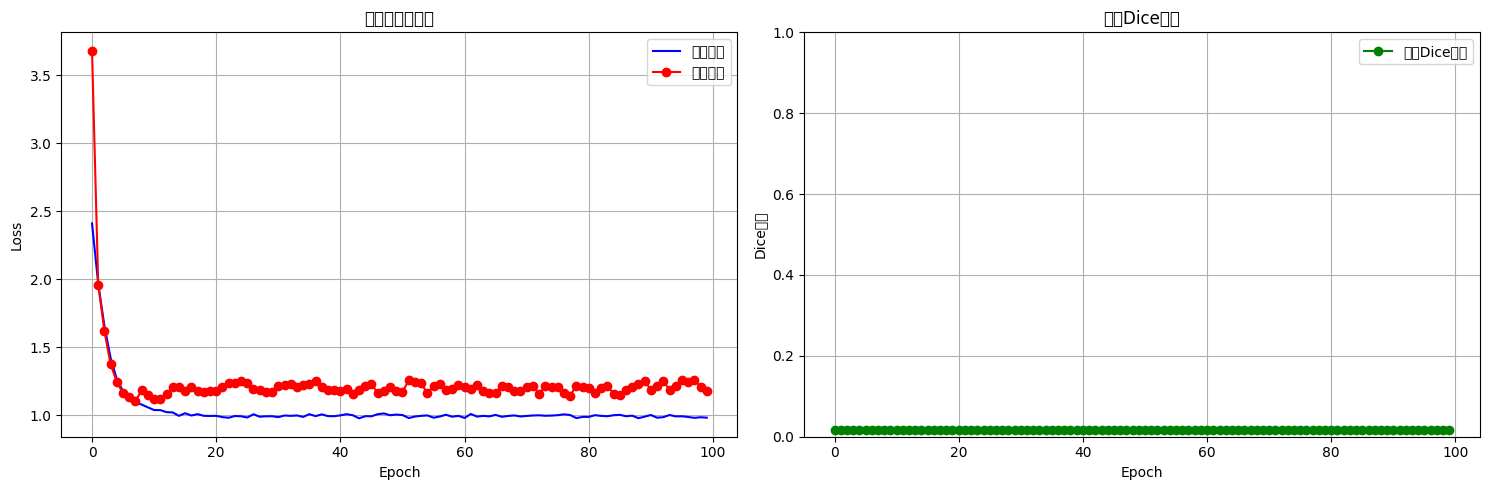

In [29]:
# 绘制训练曲线
def plot_training_history(train_losses, val_losses, val_dice_scores, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # 损失曲线
    axes[0].plot(train_losses, label='训练损失', color='blue')
    if val_losses:
        val_epochs = [i * VAL_INTERVAL for i in range(len(val_losses))]
        axes[0].plot(val_epochs, val_losses, label='验证损失', color='red', marker='o')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('训练和验证损失')
    axes[0].legend()
    axes[0].grid(True)

    # Dice系数曲线
    if val_dice_scores:
        val_epochs = [i * VAL_INTERVAL for i in range(len(val_dice_scores))]
        axes[1].plot(val_epochs, val_dice_scores, label='验证Dice系数', color='green', marker='o')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Dice系数')
        axes[1].set_title('验证Dice系数')
        axes[1].legend()
        axes[1].grid(True)
        axes[1].set_ylim([0, 1])

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

plot_training_history(train_losses, val_losses, val_dice_scores,
                     save_path=os.path.join(MODEL_SAVE_PATH, "training_history.png"))


## 11. 加载最佳模型并在测试集上评估


In [30]:
# 加载最佳模型
best_model_path = os.path.join(MODEL_SAVE_PATH, "best_model.pth")
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"加载最佳模型 (Epoch {checkpoint['epoch']}, Dice: {checkpoint['dice_score']:.4f})")
else:
    print("未找到最佳模型，使用当前模型")

# 在测试集上评估
print("\n在测试集上评估...")
test_loss, test_dice_scores, test_hausdorff_scores = val_epoch(
    model, test_loader, loss_function, dice_metric, hausdorff_metric, device
)

print(f"\n测试集结果:")
print(f"  Loss: {test_loss:.4f}")
print(f"  平均Dice系数: {test_dice_scores.mean().item():.4f}")
print(f"  Dice系数 (各类别):")

dice_array = test_dice_scores.cpu().numpy()
class_names_list = [SEGMENT_CLASSES[i] for i in range(1, NUM_CLASSES)]  # 跳过背景

for idx, class_name in enumerate(class_names_list):
    if idx < len(dice_array):
        print(f"    {class_name}: {dice_array[idx]:.4f}")
    else:
        print(f"    {class_name}: N/A (类别在真实标签中不存在)")
if test_hausdorff_scores is not None:
    print(f"  平均Hausdorff距离: {test_hausdorff_scores.mean().item():.4f}")
else:
    print(f"  平均Hausdorff距离: 计算失败（跳过）")

# 保存测试结果
test_results = {
    'test_loss': test_loss,
    'test_dice_mean': test_dice_scores.mean().item(),
    'test_dice_per_class': test_dice_scores.cpu().numpy().tolist(),
    'timestamp': datetime.now().isoformat(),
}

if test_hausdorff_scores is not None:
    test_results['test_hausdorff_mean'] = test_hausdorff_scores.mean().item()
    test_results['test_hausdorff_per_class'] = test_hausdorff_scores.cpu().numpy().tolist()
else:
    test_results['test_hausdorff_mean'] = None
    test_results['test_hausdorff_per_class'] = None

results_path = os.path.join(MODEL_SAVE_PATH, "test_results.json")
with open(results_path, 'w') as f:
    json.dump(test_results, f, indent=2)
print(f"\n测试结果已保存到: {results_path}")


加载最佳模型 (Epoch 7, Dice: 0.0163)

在测试集上评估...

测试集结果:
  Loss: 1.0935
  平均Dice系数: 0.0138
  Dice系数 (各类别):
    NECROTIC/CORE: 0.0138
    EDEMA: N/A (类别在真实标签中不存在)
    ENHANCING: N/A (类别在真实标签中不存在)
  平均Hausdorff距离: inf

测试结果已保存到: /content/drive/MyDrive/brain-tumor-models-monai/test_results.json


## 12. 可视化预测结果



测试样本 1:


Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from font(s) DejaVu Sans.
Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
Glyph 21472 (\N{CJK UNIFIED IDEOGRAPH-53E0}) missing

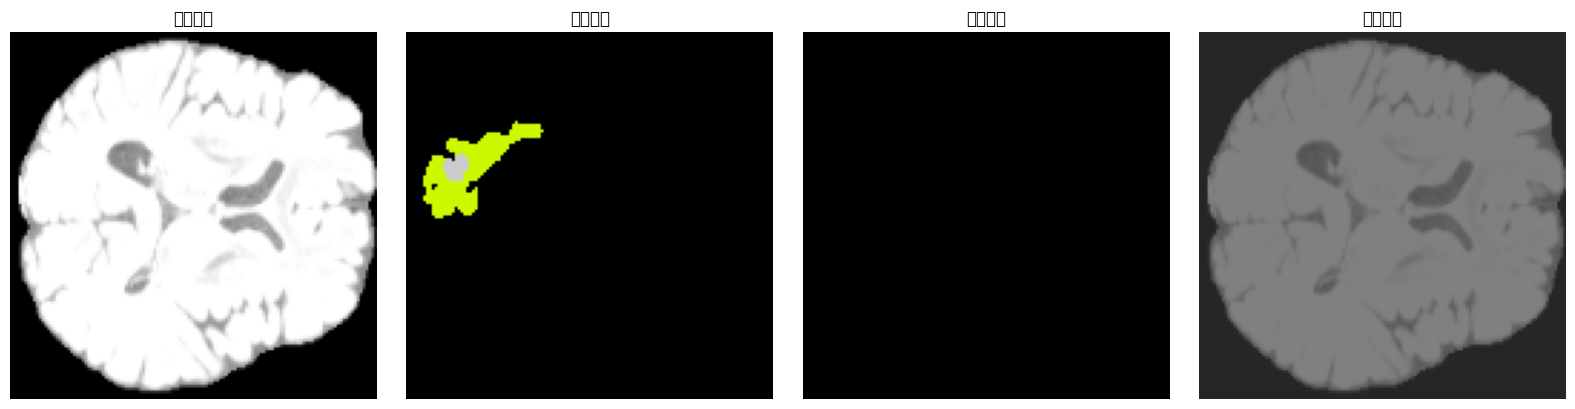


测试样本 2:


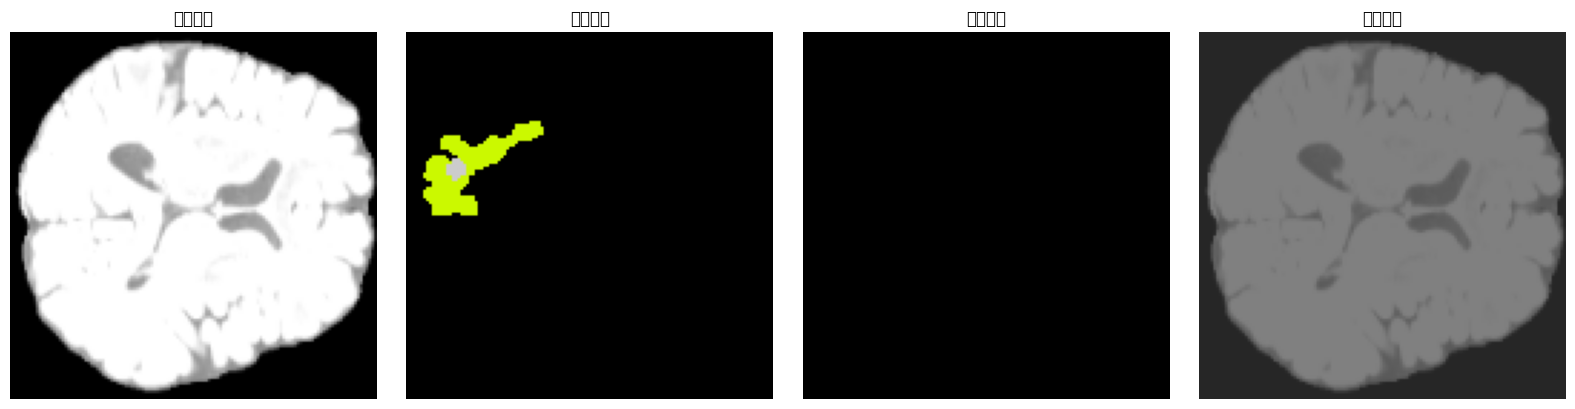


测试样本 3:


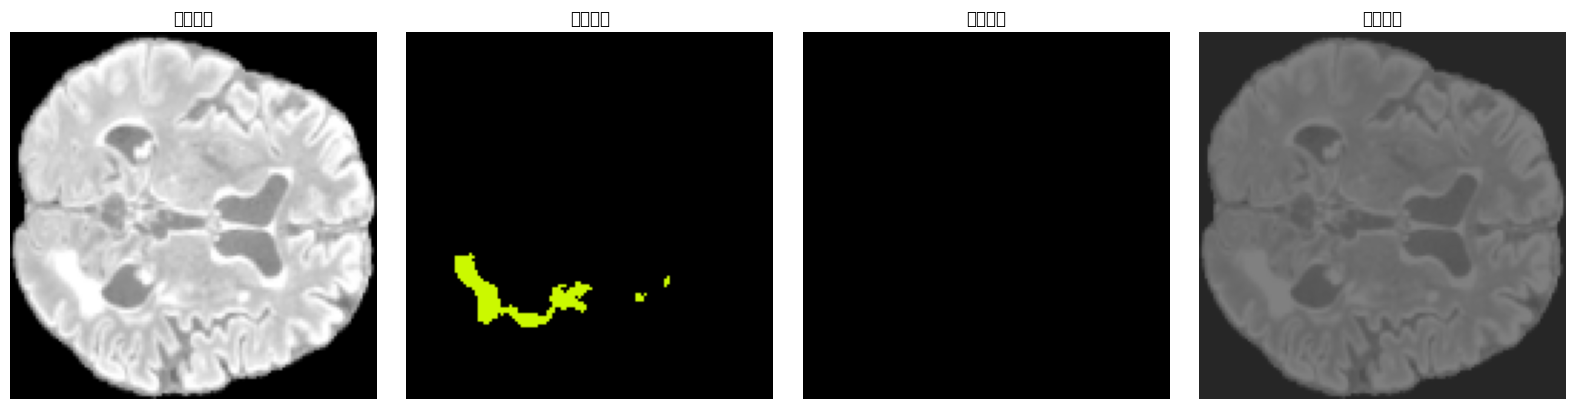

In [31]:
# 可视化预测结果
def visualize_prediction(image, label, prediction, slice_idx=None, save_path=None):
    """可视化预测结果"""
    if slice_idx is None:
        slice_idx = image.shape[-1] // 2

    # 转换为numpy
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    if isinstance(prediction, torch.Tensor):
        prediction = prediction.cpu().numpy()

    # 移除batch维度（如果有）
    if prediction.ndim == 5:
        prediction = prediction[0]
    if prediction.ndim == 4 and prediction.shape[0] > 1:
        # 如果是one-hot格式，转换为类别索引
        pred_class = np.argmax(prediction, axis=0)
    else:
        pred_class = prediction[0] if prediction.ndim == 4 else prediction

    # 获取切片
    img_slice = np.mean(image[:, :, :, slice_idx], axis=0)  # 平均多模态
    label_slice = label[0, :, :, slice_idx] if label.ndim == 4 else label[:, :, slice_idx]
    pred_slice = pred_class[:, :, slice_idx] if pred_class.ndim == 3 else pred_class

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # 原始图像
    axes[0].imshow(img_slice, cmap='gray')
    axes[0].set_title('原始图像')
    axes[0].axis('off')

    # 真实标签
    axes[1].imshow(label_slice, cmap='nipy_spectral', vmin=0, vmax=3)
    axes[1].set_title('真实标签')
    axes[1].axis('off')

    # 预测结果
    axes[2].imshow(pred_slice, cmap='nipy_spectral', vmin=0, vmax=3)
    axes[2].set_title('预测结果')
    axes[2].axis('off')

    # 叠加显示
    axes[3].imshow(img_slice, cmap='gray', alpha=0.7)
    axes[3].imshow(pred_slice, cmap='nipy_spectral', alpha=0.5, vmin=0, vmax=3)
    axes[3].set_title('叠加显示')
    axes[3].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# 在测试集上可视化几个样本
model.eval()
with torch.no_grad():
    for i, batch_data in enumerate(test_loader):
        if i >= 3:  # 只显示前3个样本
            break

        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        # 预测
        outputs = sliding_window_inference(
            inputs=inputs,
            roi_size=(IMG_SIZE, IMG_SIZE, IMG_SIZE),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
            mode="gaussian",
        )

        pred = torch.argmax(outputs, dim=1, keepdim=True)

        print(f"\n测试样本 {i+1}:")
        visualize_prediction(inputs[0], labels[0], pred[0], slice_idx=IMG_SIZE//2)


## 13. 训练总结

### 训练完成！
- ✅ 模型已保存到: `best_model.pth`
- ✅ 训练历史已保存
- ✅ 测试结果已保存到: `test_results.json`

### 下一步：
1. 可以继续训练更多epoch
2. 调整超参数（学习率、batch size等）
3. 尝试不同的模型架构
4. 与YOLOv8模型进行对比
